# Configuración entorno de ejecución

In [3]:
#@title Carga de librerias

#Text
from transformers.models.bert import BertTokenizer, BertModel, BertConfig

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
import argparse
import functools
from torch.utils.data import DataLoader

import json
import numpy as np



import argparse
import numpy as np
from collections import Counter
from tqdm import tqdm
import shutil
from sklearn.metrics import f1_score
import json
import os
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import sys
if os.path.abspath("../src") not in sys.path:
    sys.path.append(os.path.abspath("../src"))

from config import *

# 2. Dataset

In [39]:
data = pd.read_csv(TRAIN_FILE)
data = data[["Title", "Review", "Town"]]
data["text"] = data["Title"] + " " + data["Review"]
data = data[["text", "Town"]]

## 2.2 Validación de los datos

In [40]:
data.sample(10)

,text,Town
159425,"Excelente Muy buena cocina tradicional Chiapaneca, atendida por los dueños donde hacen una atención especial, con ingredientes de la región. Además de que venden artesanías típicas de los poblados cercanos.",San_Cristobal_de_las_Casas
50347,"chillaxing Por definición Chillaxing es un estado de máxima relajación y relajación y eso es exactamente lo que experimentamos en La Zebra. Éramos un grupo de cuatro. Mi esposa y yo, así como nuestras dos pequeños niños de 4 y 2. Dejaré todas las otras críticas positivas hablan por sí mismos excepto para añadir que no podíamos pedir un entorno y un servicio más perfecta. Mi esposa ha sido históricamente un ventilador de los tipos más grandes de lugares, así que me laminados dados un poco en La Zebra. resultó genial y estamos ansiosos por volver otra vez este año. Este es un lugar fantástico para los niños de cualquier edad o simplemente para una pareja. no es demasiado concurrido excepto quizás por los eventos especiales como la noche de salsa que ocurren en algunas noches, pero incluso",Tulum
25483,"Excelente Trato cordial y comida deliciosa. Ideal para probar comida da típica el personal se esmera por explicar, recomendar y servir. El ambiente es tranquilo y agradable.",San_Cristobal_de_las_Casas
114321,"Excelente lugar para comer La atención es excelente, la comida es muy buena y el lugar es súper agradable, si van a las pirámides bien vale la pena pasar al centro de Teotihuacan y disfrutar este lugar que está dentro de una pequeña plaza",Teotihuacan
119181,"Nuestra comida favorita en Sayulita La comida era muy buena en la Sayulita Café fuimos a cenar 2 noches de nuestras seis noches en Sayulita. Éramos 5 y cada bocado de cada comida era deliciosa. Pedí el plato mexicano, que incluía una excelente y brasa trozo de carne cortadas, chile...relleno, enchilada, frijoles y guacamole. Los cócteles eran también muy bueno. Fue muy divertido sentarse en mesas en la calle viendo toda la acción y la gente. Recomiendo encarecidamente este restaurante.Más",Sayulita
140477,"Excelente ubicación servicio indiferente La ubicación es de lo mejor la propiedad se encuentra en buen estado la limpieza del cuarto es buena la del baño deja mucho que desear. No t orientan en que hacer o cómo hacerlo , no te aconsejan en horarios o donde comer menos mal Que ya habíamos investigado !",Izamal
3223,"costillas y estas fabulosas Una de nuestra isla favorita lugares, vamos cada viaje. Los camareros son de lo mejor y la comida siempre es genial",Isla_Mujeres
146992,"increiblke lugar super OBLIGATORIO visitarlas, me parece emocionante estar en lugares donde hubieron tantos eventos tan importantes en la historia de México #loveit",Tulum
182287,"Gran experiencia maya! No es solamente un buen restaurante con comida yucateca rica sino que proporcionan una experiencia sensorial muy completa: el mesero Francisco nos dio un recorrido por el huerto, la choza maya donde hacen tortillas a mano, los panales de miel melipona, el altar al dios...Más",Valladolid
160202,"Centro de diversión Cuando viaje en Valladolid, mi familia y yo nos encontramos en la plaza cada día. El primer día disfrutamos de churros fresca, caliente y delicioso. Esa noche, nos quedamos sorprendidos por la gran música de domingo y las actividades para los niños (pintura, jumpee casas, etc). Otros días, nos gustaría pasear y mirar los puestos, o simplemente relajarse y observar a la gente.",Valladolid


In [41]:
data.dtypes

text    object
Town    object
dtype: object

In [42]:
data["type"]=data.Town.apply(lambda e: isinstance(e, str))

In [43]:
data[data.type==False]

,text,Town,type


In [44]:
data.dropna(inplace=True)

In [45]:
print(f"Tamaño del dataset: {len(data)}")

Tamaño del dataset: 208049


In [46]:
print(f"Tamaño del dataset muestra: {len(data)}")

Tamaño del dataset muestra: 208049


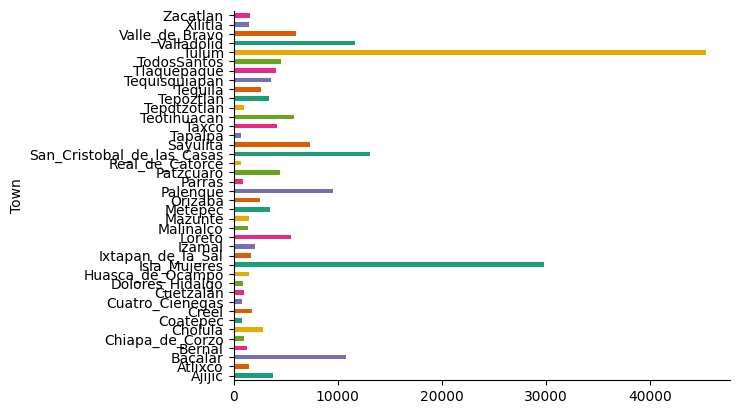

In [47]:
# @title Clases

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Town').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train, test = train_test_split(data, test_size=0.10, random_state=42)

In [50]:
train, val = train_test_split(train, test_size=0.11, random_state=42)

In [51]:
print(f"Tamaño train dataset: {len(train)}")
print(f"Tamaño test dataset: {len(test)}")
print(f"Tamaño val dataset: {len(val)}")

Tamaño train dataset: 166647
Tamaño test dataset: 20805
Tamaño val dataset: 20597


In [52]:
#save dataset
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)
val.to_csv("val.csv",index=False)

## 2.3 Procesamiento del dataset

In [ ]:
class EcommerceDataset(Dataset):
    def __init__(self, data_path, args):
        """
          data_path: ruta del archivo .csv que contiene labels y product_descriptions
          args: hiperparámetros

        """
        self.data = pd.read_csv(data_path)
        self.tokenizer = BertTokenizer.from_pretrained(args.bert_model) #función preprocesa y divide el texto en tokens
        self.args = args
        self.n_classes = len(args.labels)
        self.max_seq_len = args.max_seq_len #512


    def __len__(self):
        return len(self.data)

    def load_text(self, index, key=""):
      inputs=self.tokenizer(self.data.loc[index][key], return_tensors="pt", padding='max_length',truncation=True)
      sentence=inputs.input_ids[0]
      segment=inputs.token_type_ids[0]
      attmask=inputs.attention_mask[0]

      return sentence, segment, attmask



    def __getitem__(self, index):
      sentence, segment, attmask = None, None, None

      # Load text
      sentence, segment, attmask= self.load_text(index,"product_description")


      # Process labels
      label = torch.zeros(self.n_classes)
      tgt = self.data.loc[index]["Town"]
      label[self.args.labels.index(tgt)] = 1


      return sentence, segment, attmask, label

In [68]:
def get_labels_and_frequencies(path):
    label_freqs = Counter()
    data_labels = list(pd.read_csv(path).Town)
    label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

In [55]:
def collate_fn(batch, args):

    text_tensor, segment_tensor, attmask_tensor,= None, None, None

    text_tensor=torch.stack([row[0] for row in batch])
    segment_tensor=torch.stack([row[1] for row in batch])
    attmask_tensor=torch.stack([row[2] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    return text_tensor, segment_tensor, attmask_tensor, tgt_tensor

In [56]:
def get_data_loaders(args):

  args.labels, args.label_freqs = get_labels_and_frequencies(
            os.path.join(args.data_path, args.task, "train.csv")
        )

  args.n_classes = len(args.labels)

  train = EcommerceDataset(
            os.path.join(args.data_path, "train.csv"),
            args,
        )

  args.train_data_len = len(train)

  dev = EcommerceDataset(
        os.path.join(args.data_path, "val.csv"),
        args,
    )

  test_set = EcommerceDataset(
        os.path.join(args.data_path, "test.csv"),
        args
    )

  collate = functools.partial(collate_fn, args=args)

  train_loader = DataLoader(
        train,
        batch_size=args.batch_sz,
        shuffle=True,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  val_loader = DataLoader(
        dev,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )
  test_loader = DataLoader(
        test_set,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  return train_loader, val_loader, test_loader

# 3. Configuracion del entrenamiento general

In [57]:
import random
#Para reproducción de resultados
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [58]:
def model_forward(i_epoch, model, args, criterion, batch):

    txt, segment, attmask, tgt= batch
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()
    out = model(txt, attmask, segment) #out for supervised loss

    tgt = tgt.cuda()
    final_loss = criterion(out, tgt)

    return final_loss, out, tgt

In [59]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report

In [60]:
def model_eval(i_epoch, data, model, args, criterion):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        probs= []
        for batch in data:
            loss, out, tgt = model_forward(i_epoch, model, args, criterion, batch)
            losses.append(loss.item())

            prob = torch.nn.functional.softmax(out,dim=-1).cpu().detach().numpy()
            index_max = prob.argmax(axis=-1)
            pred = np.zeros(prob.shape)
            for i in range(len(index_max)):
                pred[i][index_max[i]]=1


            preds.append(pred)
            probs.append(prob)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    probs = np.vstack(probs)
    report = classification_report(tgts, preds, output_dict=True)
    #print(report)
    metrics = {"loss": np.mean(losses)}
    metrics = {"weighted avg": report['weighted avg']}

    return metrics

In [61]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

In [62]:
def train(args,model):
    args.savedir = os.path.join(args.savedir, args.name)
    os.makedirs(args.savedir, exist_ok=True)

    model.cuda()

    torch.save(args, os.path.join(args.savedir, "args.pt"))

    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    #Cargar estado del modelo si ya existía previamente
    if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

    len_train =len(train_loader)
    for i_epoch in range(start_epoch, args.max_epochs):
        train_losses = []
        model.train()
        optimizer.zero_grad()

        for batch in tqdm(train_loader, total=len_train):
            loss, _, _ = model_forward(i_epoch, model, args, criterion, batch)
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            train_losses.append(loss.item())
            loss.backward()
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval() #desactiva el dropout
        metrics= model_eval(i_epoch, val_loader, model, args, criterion)
        print("Train Loss: {:.4f}".format(np.mean(train_losses)))
        print("Val:", metrics)

        tuning_metric = (
            metrics['weighted avg']['f1-score']
        )

        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        #Guardar estado actual del modelo
        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
              print("No improvement. Breaking out of loop.")
              break

    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()
    test_metrics= model_eval(
        np.inf, test_loader, model, args, criterion, store_preds=True
    )
    print(f"Test:", test_metrics)

In [63]:
def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])

# 4. BERT

## 4.1 Clasificador

In [64]:
class BertClf(nn.Module):
    def __init__(self, args):
        super(BertClf, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained(args.bert_model) #Encoder
        self.dropout= nn.Dropout(args.dropout)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes) #Cabezal de clasificación

    def forward(self, txt, mask, segment):
        _, x = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        x= self.dropout(x)
        return self.clf(x)

## 4.2 Entrenamiento

### 4.1.1 BERT base

In [65]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="bert",
        batch_sz=8,
        max_seq_len=512,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=10,
        patience=2,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="bert_base_1",
    )

In [69]:
train_loader, val_loader, test_loader = get_data_loaders(args)

In [70]:
#Modelo
bert_base = BertClf(args)

In [71]:
bert_base.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [72]:
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(bert_base.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, factor=args.lr_factor
    )

torch.cuda.is_available()

True

In [ ]:
train(args,bert_base)

  0%|          | 0/20831 [00:00<?, ?it/s]

In [ ]:
def model_predict(model,text,args):
  with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    inputs=tokenizer(text, return_tensors="pt", padding='max_length',truncation=True)
    txt=inputs.input_ids
    segment=inputs.token_type_ids
    attmask=inputs.attention_mask
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()

    out = bert_base(txt, attmask, segment)
    prob = torch.nn.functional.softmax(out[0],dim=0)
    index_max = prob.argmax(axis=0)
    pred= args.labels[index_max]

  return pred, prob

In [ ]:
text="GoPro Fetch Dog Harness Mount for Camera Style name:Fetch (Dog Harness) GoPro harnais pour chiens - fetch pour HERO 1, 2, 3, 3+, 4."
model_predict(bert_base,text,args)

('Electronics',
 tensor([3.1366e-05, 7.7352e-05, 1.2388e-05, 9.9988e-01], device='cuda:0'))

In [ ]:
text="Speech and Language Processing Pasta dura – Illustrated, 1 abril 2008  Edición Inglés  por Daniel Jurafsky (Autor), James Martin (Autor) For undergraduate or advanced undergraduate courses in Classical Natural Language Processing, Statistical Natural Language Processing, Speech Recognition, Computational Linguistics, and Human Language Processing. An explosion of Web-based language techniques, merging of distinct fields, availability of phone-based dialogue systems, and much more make this an exciting time in speech and language processing. The first of its kind to thoroughly cover language technology - at all levels and with all modern technologies - this text takes an empirical approach to the subject, based on applying statistical and other machine-learning algorithms to large corporations. The authors cover areas that traditionally are taught in different courses, to describe a unified vision of speech and language processing. Emphasis is on practical applications and scientific evaluation. An accompanying Website contains teaching materials for instructors, with pointers to language processing resources on the Web. The Second Edition offers a significant amount of new and extended material"
model_predict(bert_base,text,args)

('Books',
 tensor([9.9993e-01, 1.1027e-05, 1.4836e-05, 4.6559e-05], device='cuda:0'))

In [ ]:
text="U.S. Polo Assn. Men's Cotton Casual Jacket U.S. Polo Assn. Men Dark Blue Plain / Solid Sleeveless V-neck Regular Fit Casual XXX-Large Waistcoats"
model_predict(bert_base,text,args)

('Clothing & Accessories',
 tensor([1.2601e-05, 7.7216e-05, 9.9989e-01, 1.6155e-05], device='cuda:0'))

In [ ]:
text = "BESTONZON 2pcs Wooden Crepe Spreader Pancake Maker Batter Dough Spreader DIY Kitchen Tool Size:2 pcs DescriptionMade of high quality wood, it is safe, non-toxic and durable. Pour your batter into the pan and use the spreader in a circular motion to spread the batter. You can make delicious crepes easily with the right tool"
model_predict(bert_base,text,args)

('Household',
 tensor([8.7531e-06, 9.9994e-01, 1.0355e-05, 4.5056e-05], device='cuda:0'))

In [ ]:
bert_base.cuda()
text="iphone 12 4gb ram"
model_predict(bert_base,text,args)

('Electronics',
 tensor([5.5867e-05, 5.4739e-05, 8.2725e-06, 9.9988e-01], device='cuda:0'))

In [ ]:
bert_base.cuda()
text="IPHONE 12 4GB RAM"
model_predict(bert_base,text,args)

('Electronics',
 tensor([5.5867e-05, 5.4739e-05, 8.2725e-06, 9.9988e-01], device='cuda:0'))